# Assignment 1: Perceptron Learning

The goal of this exercise is to apply the perceptron learning to a total of $N=100$ automatically generated, separable random data $X=\bigl\{\vec x^1, \vec x^2,\ldots,\vec x^ N \bigr\}$ with each $\vec x^n = \bigl(x_1^n, x_2^n\bigr)^T$.
Each data point $\vec x^n$ is accompanied by an according target value $X=\bigl\{t^1, t^2,\ldots,t^ N\bigr\}$ with $t^n \in \{-1,+1\}$.

## Data Generation
The data should be generated such that
$\forall n\leq\frac N2\colon \vec x^n \sim \mathcal N_{\vec\mu_+, \sigma_+}$.
These samples will be our positive data labeled with $t^n=1$.
Similarly, we generate our negative data with
$\forall n>\frac N2\colon \vec x^n \sim \mathcal N_{\vec\mu_-, \sigma_-}$
and label them as $t^n=-1$.

### Task 1: Data Samples

Given the number of samples and the means (mu) and standard deviations (sigma) of positive (pos) and negative (neg) data, generate and return data samples including their labels. Remember to add the bias neuron $x_0=1$ to each of the samples.

Hints:
1. Use `numpy` package to generate data.
2. Exemplary means could be selected as: $\vec\mu_+=(-5,3)^T$ and $\vec\mu_- = (5, -3)^T$. The standard deviations $\sigma_+$ and $\sigma_-$ should be selected such that the data is most likely separable.

In [1]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

ModuleNotFoundError: No module named 'sklearn'

In [1]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

ModuleNotFoundError: No module named 'pandas'

In [1]:
import numpy as np
import random

def expand_with_ones(X):
    # add a column of ones to the front of the input matrix
        
    X_out = np.c_[np.ones(X.shape[0]) , X ]            
    return X_out

def dataset(number_of_samples, mu_pos, sigma_pos, mu_neg, sigma_neg):
    n_of_samples_per_category = int(number_of_samples/2)
    
    # create positive and negative data
    positive_data = np.random.default_rng().normal(mu_pos, sigma_pos, size=(n_of_samples_per_category, 2))
    negative_data = np.random.default_rng().normal(mu_neg, sigma_neg, size=(n_of_samples_per_category, 2))

    # assign positive and negative labels
    positive_labels = np.ones(50)
    negative_labels = np.ones(50) * -1

    # concatenate positive and negative data
    all_data = np.concatenate((positive_data, negative_data), axis=0)
    all_labels = np.concatenate((positive_labels, negative_labels), axis=0)

    # anything else to consider?
    
    # add the bias column to the data
    all_data = expand_with_ones(all_data)
    
    data_zip = list(zip(all_data,all_labels))
    random.shuffle(data_zip)
    
    all_data = []
    all_labels = []
    for pair in data_zip:
        all_data.append(pair[0])
        all_labels.append(pair[1])

    
    # return both X and T
    return np.asarray(all_data), np.asarray(all_labels)

### Task 2: Select Data Parameters and Line Parameters

We want to select data points such that we exactly know where the ideal separating line should be placed.
Note that data samples are not always separable since they are generated randomly.
You should determine, which means and standard deviations are useful.

Once you have defined your means, you should also define the separating line.
The easiest is to provide it as Cartesian equation: $w_0 + w_1 x_1 + w_2 x_2$.
Note that the separating line is orthogonal to the vector $\overrightarrow{\vec\mu_- \vec\mu_+}$, that the normal of the line $(w_1, w_2)^T$ is orthogonal to the line, and that $w_0$ should be selected such that the line $\vec w$ is in the middle of $\vec\mu_+$ and $\vec\mu_-$.

In [2]:
def least_squares_compute_parameters(X_input, y):


    # compute the parameters based on the expanded X and y using the least-squares method    
    w = np.linalg.lstsq(X,y, rcond=None)[0]
    
    return w


In [3]:
X, T = dataset(100,  mu_pos=[5,-3], sigma_pos=1.2, mu_neg=[-3,5], sigma_neg=1.5)

w_manual = least_squares_compute_parameters(X, T)

### Test 1: Linear Separability Test

A line $a = f_{\vec w}(\vec x) = w_0 + w_1 x_1 + w_2 x_2$ linearly separates the data $(X,T)$ if $\forall n: a^{[n]} t^{[n]} > 0$ for $a^{[n]} = f_{\vec w}(\vec x^{[n]})$.
The below function implements this linear separability test. We apply this test to your data $(X,T)$ from Task 1 and your manually selected line $\vec w$ from Task 2 to assure that the line separates the data.

In [4]:
def separability_test(X, T, w):
    res = np.dot(X,w) * T > 0
    return np.all(res)

# Test 1: check that the weights are separating the data
if separability_test(X, T, w_manual):
    print("The data is separated by the manually selected line")
else:
    print("The anually selected line does not separate the data")

The data is separated by the manually selected line


### Task 3: Perceptron

The perceptron is defined as the Adaline $$a = f_{\vec w}(\vec x)$$ that is thresholded using the sign function $$\mathrm{sign}(a) = \begin{cases} +1 &\text{if } a \geq 0\\ -1 & \text{otherwise.}\end{cases}$$
Implement a function that computes and returns the perceptron for a given data point $\vec x$ and line parameters $\vec w$.

In [5]:
def perceptron(x, w):
    h = np.dot(x,w)
    
    y_ = np.where(h >= 0.0, 1, -1)
    return y_

## Perceptron Learning

The perceptron learning rule is defined as follows.
First, the weights $\vec w = (w_0, w_1, w_2)^T$ is initialized randomly.
Then, for each sample $(x,t)$ of the dataset we check if the sample is correctly classified as $H(f_{\vec w}(\vec x)) t > 0$.
If the sample is classified incorrectly, the weights are adapted: $w_0 = w_0 + t$, $w_1 = w_1 + tx_1$, $w_2 = w_2 + tx_2$.
This step is repeated until all samples are classified correctly.


### Task 4: Perceptron Learning Implementation

Implement a function that performs perceptron learning for a given dataset $(X,T)$ and a given initial weight vector $\vec w$.
The final weight vector $\vec w^*$ shall be returned from that function.
Define a proper stopping criterion for the iteration.
Consider in your implementation error cases that could arise.


In [6]:
def perceptron_learning(X, T, w):
    # first, make a copy of your weights
    
    w_star = w.copy()


    # then, iterate over the data and perform perceptron learning
    for x, t in list(zip(X, T)):
        y_ = perceptron(x, w_star)
        
        if y_ * t < 0:
            w_star = w_star + t * x

    # finally, return the optimal weights
    return w_star

### Test 2: Sanity Check

We call the perceptron learning function with the data from task 1 and the manual line from task 2. If the line separates the data, it should not be changed. Here we test if this is the actual outcome of the perceptron learning function.

In [7]:
w_star = perceptron_learning(X, T, w_manual)

# check if the output is as expected
if np.any(w_manual != w_star):
    print("Warning: the perceptron algorithm seems to be wrong")
else:
    print("As desired, perceptron learning does not optimize an already separating line")

As desired, perceptron learning does not optimize an already separating line


### Task 5: Weight Initialization

Implement a function that generates and returns randomly initialized weights $\vec w \in [-1,1]^3$.

In [8]:
def random_weights(input_size, output_size, lowest = -1, highest = 1):
    # The Glorot normal initializer, also called Xavier normal initializer
    w = np.random.uniform(lowest, highest, (output_size, input_size))
    w *= np.sqrt(1/w.shape[1]) * 0.01
    return w.reshape((-1,))

### Task 6: Perceptron Learning Execution

Call the perceptron learning function with the data from task 1 and the randomly generated initial weight vector from task 5.
Store the resulting weight vector $\vec w^*$.

In [9]:
# create random weights
w_initial = random_weights(X.shape[1], 1)

# perform perceptron learning
w_star = perceptron_learning(X, T, w_initial)


### Test 3: Result Validation

We verify that the optimized $\vec w^*$ actually separates the data.

In [10]:
# verify that we have learned to separate the data
if separability_test(X, T, w_star):
    print("The data is separated by the optimal line")
else:
    print("The optimal line does not separate the data")

The data is separated by the optimal line


## Visualization

We have selected our data to be 2-dimensional to be able to visualize the results.
For this purpose, we would like to jointly plot the positive and the negative data from Task 1 together with the decision boundaries of the weight vectors obtained in Tasks 2 and 6.
An example can be found in the exercise slides.

### Task 7: Plotting

First, we need to plot the data points such that positive data are plotted with green dots, and negative data with red dots.

Then, we need to compute the line parameters. For this purpose, we define the separating line in Cartesian coordinates $f_{\vec w}(\vec x) = 0$ and solve it to the parametric form $x_2 = \beta x_1 + \gamma$.

Ellipsis

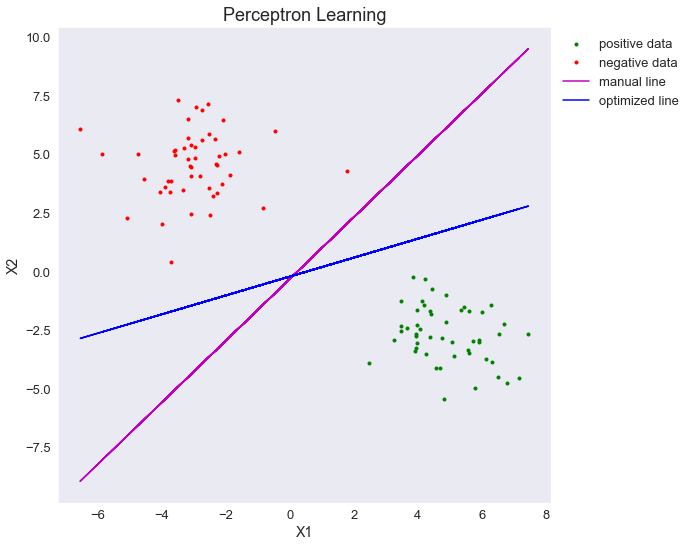

In [11]:
def line_parameters(w):
  # compute parametric line parameters from Cartesian coordinates
  beta = - (w[1]/w[2])
  gamma = - (w[0]/w[2])
  return beta, gamma

from matplotlib import pyplot
import seaborn as sns

sns.set_style('dark') # darkgrid, white grid, dark, white and ticks
pyplot.rc('axes', titlesize=18)     # fontsize of the axes title
pyplot.rc('axes', labelsize=14)    # fontsize of the x and y labels
pyplot.rc('xtick', labelsize=13)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=13)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=13)    # legend fontsize
pyplot.rc('font', size=20)          # controls default text sizes

# create a square plot
pyplot.figure(figsize=(10,8), tight_layout=True)
pyplot.xlabel('X1')
pyplot.ylabel('X2')
pyplot.title('Perceptron Learning')

# plot the positive data points
pyplot.plot(X[:,1][T>0], X[:,2][T>0], "g.", label="positive data")
# plot the negative data points
pyplot.plot(X[:,1][T<0], X[:,2][T<0], "r.", label="negative data")

# define positions where to evaluate the line:
x1 = X[:,1]

# compute line parameters for manual line
beta, gamma = line_parameters(w_manual)
# now, compute the values according to our parametric form:
x2 = beta * x1 + gamma
# plot lines (might need to call this function twice for the two lines)
pyplot.plot(x1, x2, "m-", label="manual line")

# compute line parameters for optimized line
beta, gamma = line_parameters(w_star)
# now, compute the values according to our parametric form:
x2 = beta * x1 + gamma
# plot lines (might need to call this function twice for the two lines)
pyplot.plot(x1, x2, "b-", label="optimized line")

pyplot.legend(frameon=False, loc="upper left", bbox_to_anchor=(1,1))
...